In [36]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import dataset
data = pd.read_csv("https://raw.githubusercontent.com/lecriste/LDC/main/commodities.csv?token=GHSAT0AAAAAABQQRHJDKH6F724MSYM5OSI2YQBCXVA")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19019 entries, 0 to 19018
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19019 non-null  object 
 1   instrument   19019 non-null  object 
 2   maturity     19019 non-null  object 
 3   observation  19019 non-null  object 
 4   value        19019 non-null  float64
 5   currency     19019 non-null  object 
dtypes: float64(1), object(5)
memory usage: 891.6+ KB


In [4]:
# Check for single-value features
for feature in data:
    if data[feature].nunique() == 1:
        print(feature)

currency


In [5]:
currency = data['currency'][0]

In [6]:
# Drop single-value feature
data.drop('currency', axis=1, inplace=True)

In [7]:
# Convert date values to "datetime" format
data['date'] = pd.to_datetime(data['date'])

In [8]:
# List commodities
commodities = data.groupby(['instrument']).nunique()
commodities

,date,maturity,observation,value
instrument,,,,
CBOT.ZC,231,17,3,1047
CBOT.ZS,231,30,3,1931


In [9]:
corn = [commodities.index[0], 'Corn']
soy = [commodities.index[1], 'Soybeans']

In [10]:
# Split dataset per commodity
dataCorn = data[data['instrument'] == corn[0]].drop('instrument', axis=1)
dataSoy = data[data['instrument'] == soy[0]].drop('instrument', axis=1)

In [11]:
def sort_maturities(df):
    #maturities = df.groupby(['maturity']).nunique()
    #maturities.sort_index(key = lambda m: m[1:]+m[-1])
    maturities = df.groupby(['maturity']).nunique().index
    maturities_sorted = list(maturities)
    maturities_sorted.sort(key=lambda m: m[-1])
    return maturities_sorted

In [12]:
def plotAll(comm, df, maturities_sorted):
    plt.figure(figsize=(16*2, 9*2))
    ax = df[df['maturity'] == 0].plot(x='date')
    ax.clear()
    plt.title(comm+" price by maturity")
    plt.ylabel(currency)
    
    df_dateIdx = df.set_index('date')
    linear = {}
    for m in maturities_sorted:
        df[df['maturity'] == m].plot(x='date', ax=ax, legend=False)
        #linear[m] = df['value'][df['maturity'] == m].interpolate()
        #method='time': time-weighted interpolation only works on Series or DataFrames with a DatetimeIndex
        linear[m] = df_dateIdx['value'][df_dateIdx['maturity'] == m].interpolate( \
                                                                     method='time')
    plt.legend(maturities_sorted, bbox_to_anchor=(1., 1.1))
    
    return linear

In [34]:
def minmax(comm, metric, data, whole_year, error=False):
    #minIdx = min(data, key=data.get)
    minIdx = min(data, key = lambda m: \
                 data.get(m)[0] if data.get(m)[2] == whole_year else sys.float_info.max)
    #maxIdx = max(data, key=data.get)
    maxIdx = max(data, key = lambda m: \
                 data.get(m)[0] if data.get(m)[2] == whole_year else sys.float_info.min)
    metrics = {'minimum': minIdx, 'maximum': maxIdx}
    for m in metrics:
        err = "" if (not error) else "+/- {:.0f} ".format(data[metrics[m]][1])
        print("In 2021, the %s maturity-%s of %s price was %.0f %s%s for %s." \
              % (m, metric, comm, data[metrics[m]][0], err, currency, metrics[m]))

In [32]:
def getMean(comm, df, maturities_sorted, whole_year):
    means = {}
    for m in maturities_sorted:
        obs = df['date'][df.maturity == m].count()
        means[m] = (df['value'][df.maturity == m].mean() \
                    , df['value'][df.maturity == m].std() \
                    , obs)
    minmax(comm, "average", means, whole_year, True)

    return means

In [31]:
def getSpread(comm, df, linear, whole_year, days, verbose=False):
    spreads = {}
    for m in linear:
        obs = df['date'][df.maturity == m].count()
        spread = df['value'][df.maturity == m].max() - df['value'][df.maturity == m].min()
        if (df['date'][df['value'][df.maturity == m].idxmax()] <  df['date'][df['value'][df.maturity == m].idxmin()]):
            spread *= -1
        slope = (linear[m].iloc[-1] - linear[m].iloc[0]) / days
        spreads[m] = (spread, slope, obs)
        
        if verbose:
            if obs < whole_year:
                print("\nIn only part of 2021:")
            else:
                print("\nIn the whole 2021:")
            print("the maximum spread of %s %s is %.2f %s," % (corn[1], m, spread, currency))
            print("with an average trend of %+.2f %s per day." % (slope, currency))
    minmax(comm, "spread", spreads, whole_year)

    return spreads

In [16]:
def plotByYear(comm, df, maturities_sorted):
    maturities_year = sorted(set([m[1:] for m in maturities_sorted]))
    for y in maturities_year:
        plt.figure(figsize=(16*2, 9*2))
        ax = df[df['maturity'] == 0].plot(x='date', ylabel=currency, legend=False)
        ax.clear()
        plt.title(comm+" price with maturity in "+y)
        plt.ylabel(currency)
        legend = []

        for m in maturities_sorted:
            if y in m:
                df[df['maturity'] == m].plot(x='date', y='value', ax=ax, legend=False)
                legend.append(m)
        plt.legend(legend, bbox_to_anchor=(1., 1.))

In [22]:
def inspectDataset(df, comm):
    print("Inspecting "+comm+" dataset:")
    print(df)
    print("\nGroup by maturity:")
    print(df.groupby(['maturity']).nunique())
    whole_year = df.groupby(['maturity']).nunique()['date'].max()
    days = (df['date'].max() - df['date'].min()).days
    
    df_Settle = df[df.observation == 'Settle']
    maturities_sorted = sort_maturities(df_Settle)
    
    # General overview
    linear = plotAll(comm, df_Settle, maturities_sorted)
    
    # Means
    print("\nCalculate average price per maturity:")
    means = getMean(comm, df_Settle, maturities_sorted, whole_year)
    
    # Group by maturity year
    print("\nCalculate price spread per maturity:")
    plotByYear(comm, df_Settle, maturities_sorted)
    
    # Slopes
    spreads = getSpread(comm, df_Settle, linear, whole_year, days)
    
    # Summary
    metrics = pd.DataFrame(index=range(0, len(maturities_sorted))\
                           , columns=("Maturity","Observations [%]","Spread","Slope (/day)","Mean","Std")\
                           , dtype=float)
    for m in metrics.index:
        mat = maturities_sorted[m]
        metrics.loc[m] = [mat, spreads[mat][2]/whole_year *100, spreads[mat][0], spreads[mat][1]\
                          , means[mat][0], means[mat][1]]

    return metrics

Inspecting Corn dataset:
                           date maturity observation   value
10215 2021-01-04 00:00:00+00:00    H2021        High  497.75
10216 2021-01-04 00:00:00+00:00    H2021         Low  479.50
10217 2021-01-04 00:00:00+00:00    H2021      Settle  483.75
10218 2021-01-04 00:00:00+00:00    K2021        High  497.25
10219 2021-01-04 00:00:00+00:00    K2021         Low  480.25
...                         ...      ...         ...     ...
19014 2021-12-01 00:00:00+00:00    Z2023        High  507.75
19015 2021-12-01 00:00:00+00:00    Z2023         Low  505.75
19016 2021-12-01 00:00:00+00:00    Z2023      Settle  507.50
19017 2021-12-01 00:00:00+00:00    N2024      Settle  515.75
19018 2021-12-01 00:00:00+00:00    Z2024      Settle  480.50

[8804 rows x 4 columns]

Group by maturity:
          date  observation  value
maturity                          
H2021       48            3    109
H2022      231            3    410
H2023      231            3    306
K2021       92         

,Maturity,Observations [%],Spread,Slope (/day),Mean,Std
0,H2021,21.0,81.25,0.20,537.0,22.0
1,K2021,40.0,288.50,0.61,578.0,74.0
2,N2021,58.0,250.00,0.61,594.0,72.0
3,U2021,76.0,207.50,0.17,533.0,49.0
4,Z2021,100.0,206.25,0.42,526.0,47.0
5,H2022,100.0,202.50,0.40,533.0,47.0
6,K2022,100.0,198.50,0.40,537.0,47.0
7,N2022,100.0,195.50,0.40,537.0,46.0
8,U2022,100.0,161.50,0.44,497.0,44.0
9,Z2022,100.0,161.00,0.44,485.0,44.0


<Figure size 2304x1296 with 0 Axes>

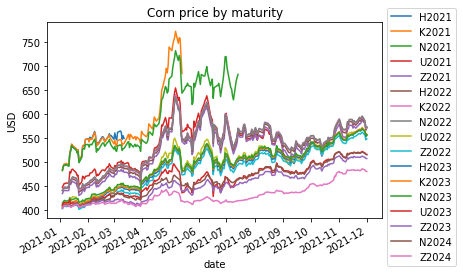

<Figure size 2304x1296 with 0 Axes>

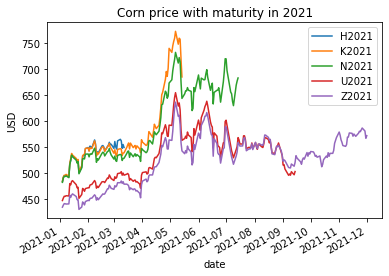

<Figure size 2304x1296 with 0 Axes>

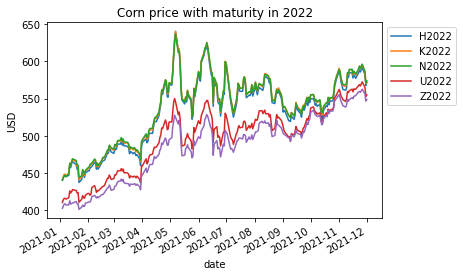

<Figure size 2304x1296 with 0 Axes>

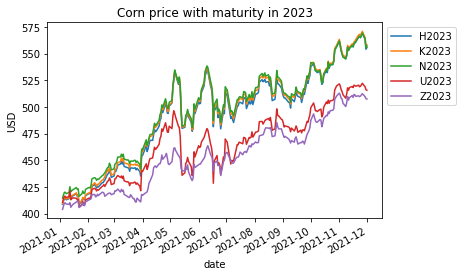

<Figure size 2304x1296 with 0 Axes>

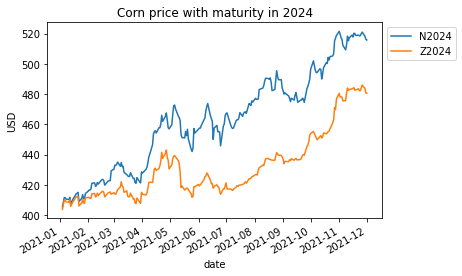

In [39]:
metrics = inspectDataset(dataCorn, corn[1])
#metrics.style.format(precision=0)
metrics.round({"Observations [%]": 0,"Spread": 2, "Slope (/day)": 2, "Mean": 0, "Std": 0})

Inspecting Soybeans dataset:
                           date maturity observation    value
0     2021-01-04 00:00:00+00:00    F2021        High  1349.75
1     2021-01-04 00:00:00+00:00    F2021         Low  1306.25
2     2021-01-04 00:00:00+00:00    F2021      Settle  1316.50
3     2021-01-04 00:00:00+00:00    H2021        High  1349.50
4     2021-01-04 00:00:00+00:00    H2021         Low  1301.00
...                         ...      ...         ...      ...
10210 2021-12-01 00:00:00+00:00    X2024        High  1116.50
10211 2021-12-01 00:00:00+00:00    X2024         Low  1116.00
10212 2021-12-01 00:00:00+00:00    X2024      Settle  1116.50
10213 2021-12-01 00:00:00+00:00    N2025      Settle  1116.50
10214 2021-12-01 00:00:00+00:00    X2025      Settle  1113.50

[10215 rows x 4 columns]

Group by maturity:
          date  observation  value
maturity                          
F2021        9            3     26
F2022      231            3    485
F2023      231            3    275
F2024 

,Maturity,Observations [%],Spread,Slope (/day),Mean,Std
0,F2021,4.0,120.00,0.36,1379.0,38.0
1,H2021,21.0,129.50,0.31,1385.0,30.0
2,K2021,40.0,349.25,0.88,1431.0,81.0
3,N2021,58.0,344.00,0.50,1432.0,80.0
4,Q2021,67.0,318.50,0.48,1394.0,72.0
5,U2021,76.0,325.25,0.32,1320.0,76.0
6,X2021,95.0,347.50,0.34,1281.0,80.0
7,F2022,100.0,354.25,0.33,1282.0,80.0
8,H2022,100.0,351.50,0.42,1269.0,80.0
9,K2022,100.0,353.25,0.46,1268.0,81.0


<Figure size 2304x1296 with 0 Axes>

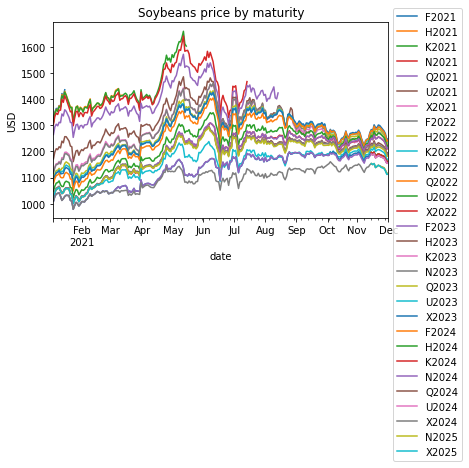

<Figure size 2304x1296 with 0 Axes>

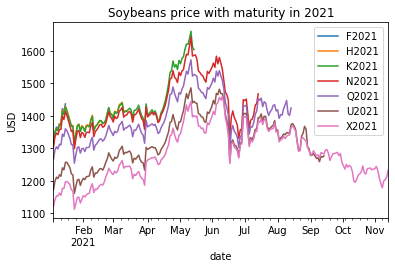

<Figure size 2304x1296 with 0 Axes>

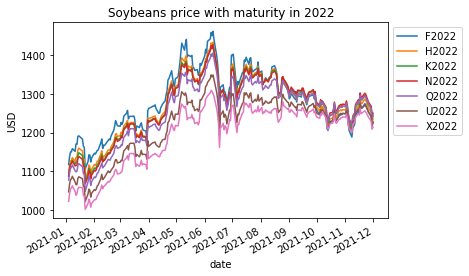

<Figure size 2304x1296 with 0 Axes>

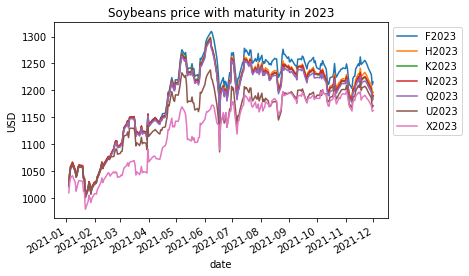

<Figure size 2304x1296 with 0 Axes>

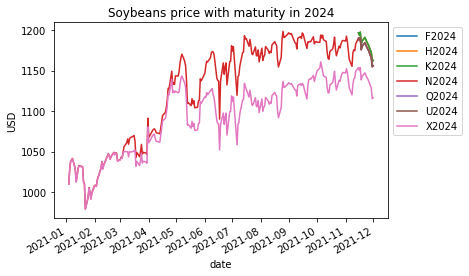

<Figure size 2304x1296 with 0 Axes>

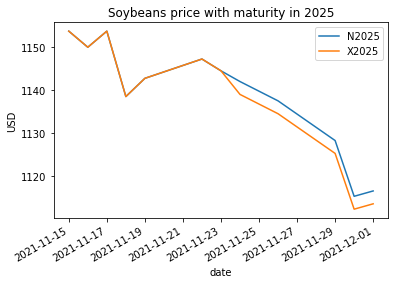

In [38]:
metrics = inspectDataset(dataSoy, soy[1])
metrics.round({"Observations [%]": 0, "Spread": 2, "Slope (/day)": 2, "Mean": 0, "Std": 0})